In [5]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [6]:
importlib.reload(putil)
importlib.reload(ces)
from IPython.display import clear_output

# ----- get data
kwargs = {'freq':'monthly', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':False}
T_           = putil.get_variable('T', **kwargs)
u_           = putil.get_variable('U', **kwargs)
utendepfd_   = putil.get_variable('utendepfd', **kwargs)
utendresvel_ = putil.get_variable('utendresvel', **kwargs)
utendgw_     = putil.get_variable('utendgw', **kwargs)
utenddiff_   = putil.get_variable('utenddiff', **kwargs)
epfy_        = putil.get_variable('epfy', **kwargs)
epfz_        = putil.get_variable('epfz', **kwargs)
psitem_      = putil.get_variable('psitem', **kwargs)
psitem_gp_   = putil.get_variable('psitem_gradlat', **kwargs)
psitem_glat_ = putil.get_variable('psitem_gradp', **kwargs)
trop_        = putil.get_variable('TROP_P', **kwargs)
clear_output()

In [10]:
importlib.reload(putil)
importlib.reload(ces)

# ----- extract counterfactual ensemble mean and members
T, T_mem                     = T_['cfmean'], T_['cf_members']
u, u_mem                     = u_['cfmean'], u_['cf_members']
utendepfd, utendepfd_mem     = utendepfd_['cfmean'], utendepfd_['cf_members']
utendresvel, utendresvel_mem = utendresvel_['cfmean'], utendresvel_['cf_members']
utendgw, utendgw_mem         = utendgw_['cfmean'], utendgw_['cf_members']
utenddiff, utenddiff_mem     = utenddiff_['cfmean'], utenddiff_['cf_members']
epfy, epfy_mem               = epfy_['cfmean'], epfy_['cf_members']
epfz, epfz_mem               = epfz_['cfmean'], epfz_['cf_members']
psitem, psitem_mem           = psitem_['cfmean'], psitem_['cf_members']
psitem_gp, psitem_gp_mem     = psitem_gp_['cfmean'], psitem_gp_['cf_members']
psitem_glat, psitem_glat_mem = psitem_glat_['cfmean'], psitem_glat_['cf_members']
trop, trop_mem               = trop_['cfmean'], trop_['cf_members']

# ----- combine data, make month coordinate
allvars = [T, u, utendepfd, utendresvel, utendgw, utenddiff, epfy, epfz, psitem, psitem_gp, psitem_glat, trop]
cf = xr.merge(allvars)

# ----- combine member-level data, make month coordinate
allvars = [T_mem, u_mem, utendepfd_mem, utendresvel_mem, utendgw_mem, utenddiff_mem, 
           epfy_mem, epfz_mem, psitem_mem, psitem_gp_mem, psitem_glat_mem, trop_mem]
cf_mem = xr.merge(allvars)
N = len(cf_mem.ens)

# ----- get climatology
climo = putil.climatology(cf)

/tmp/ipykernel_2099566/1818194750.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


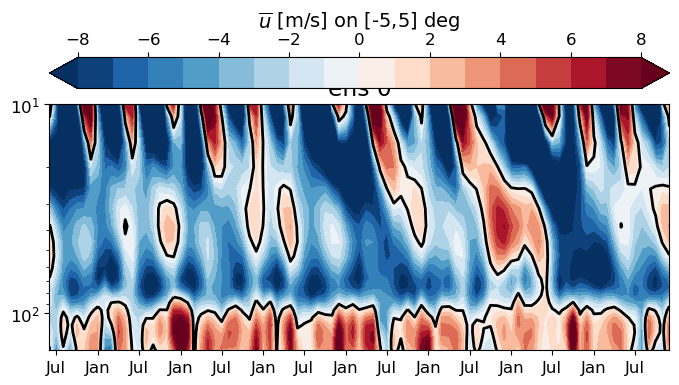

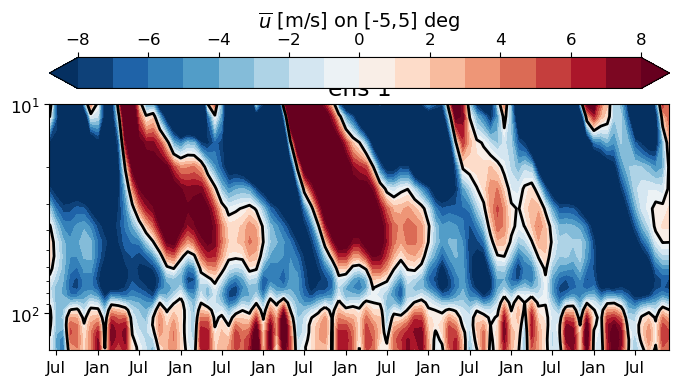

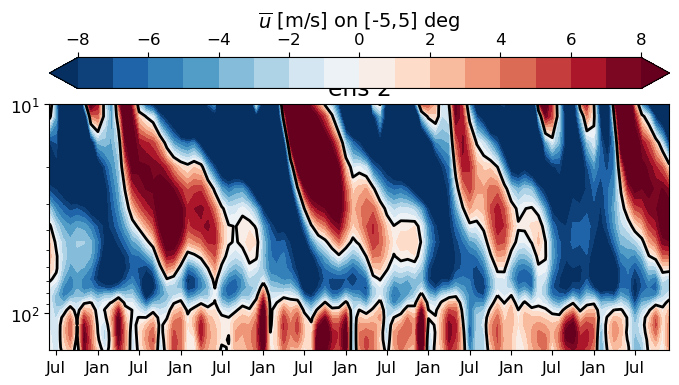

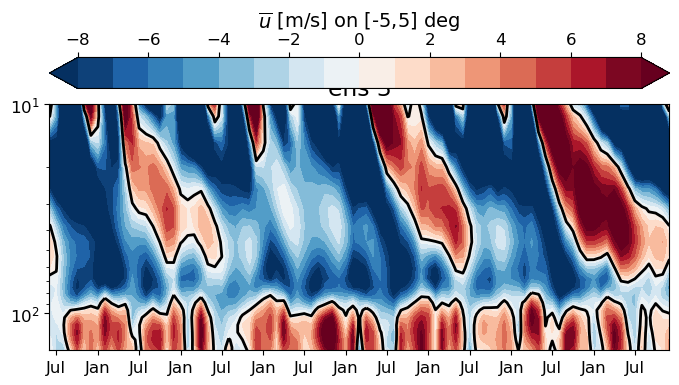

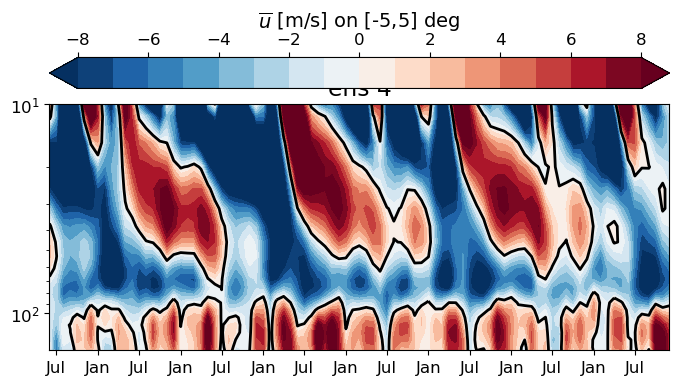

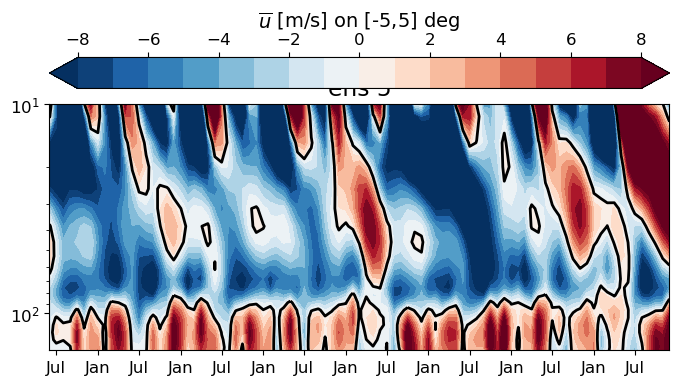

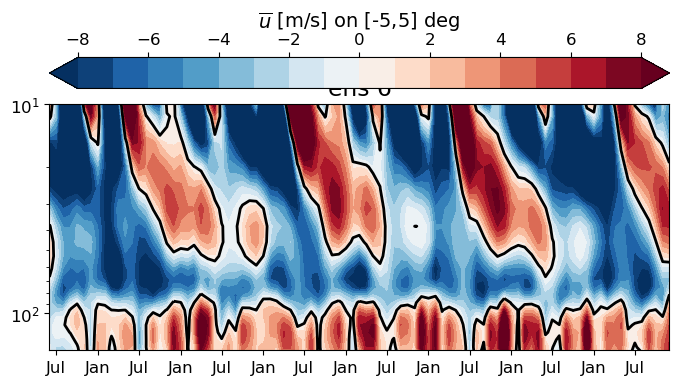

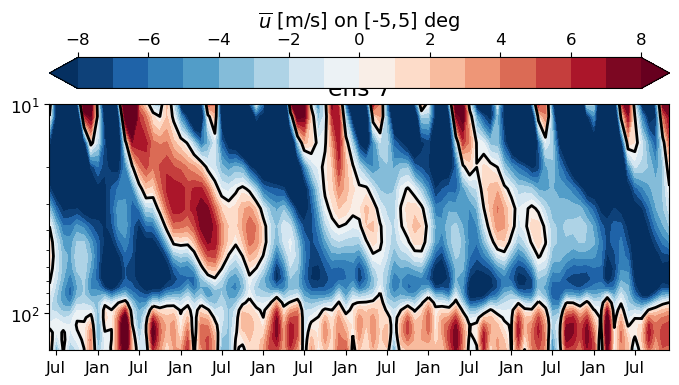

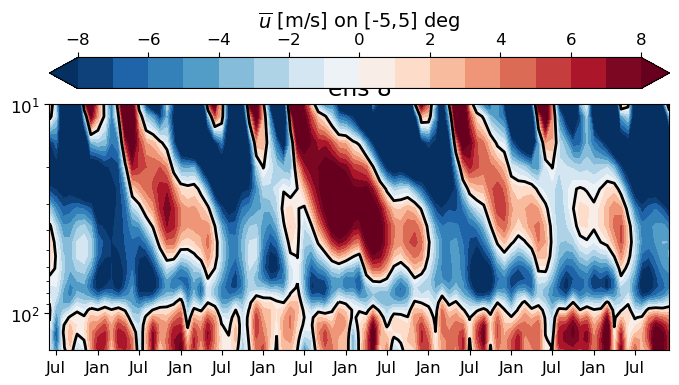

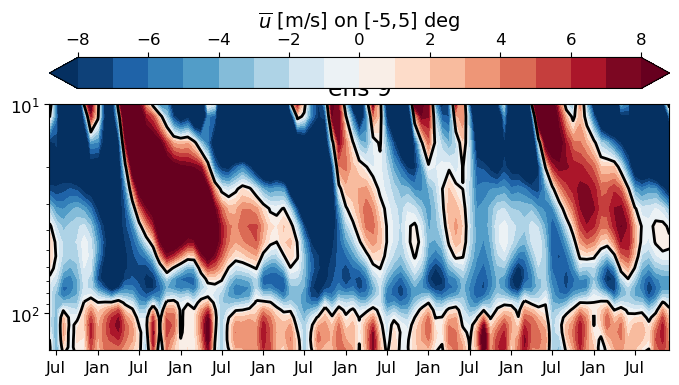

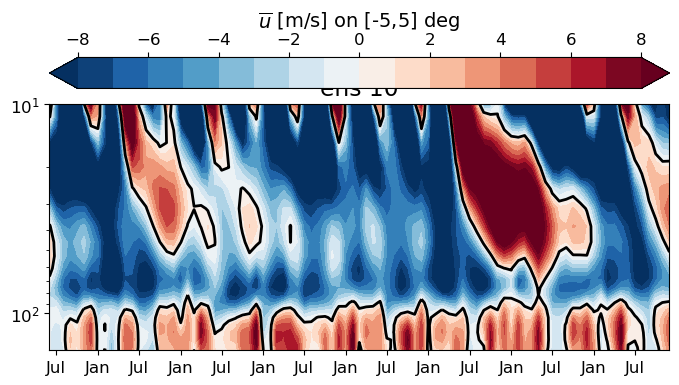

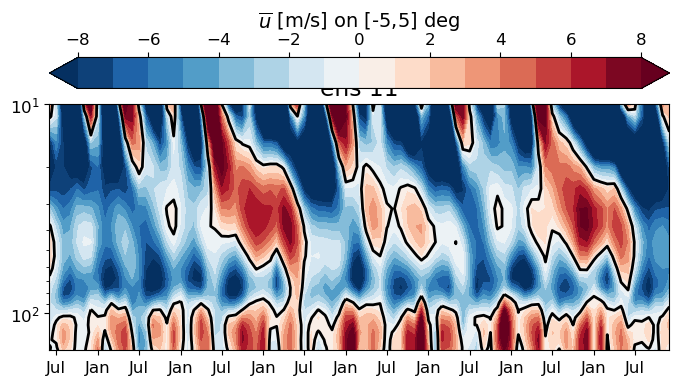

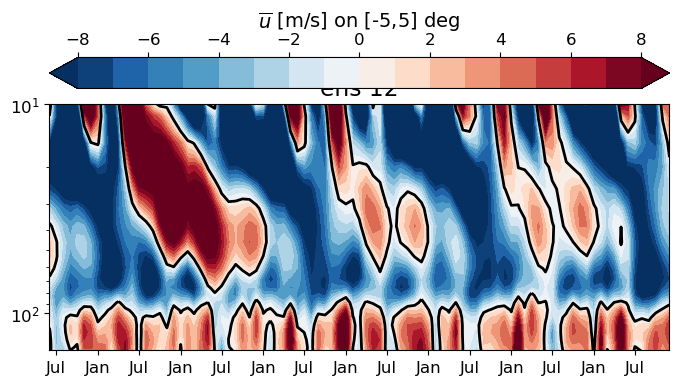

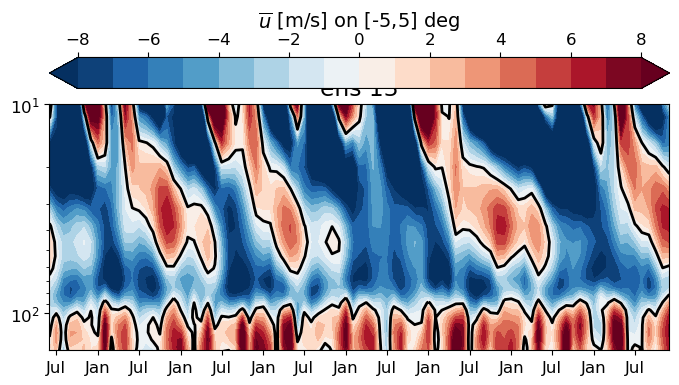

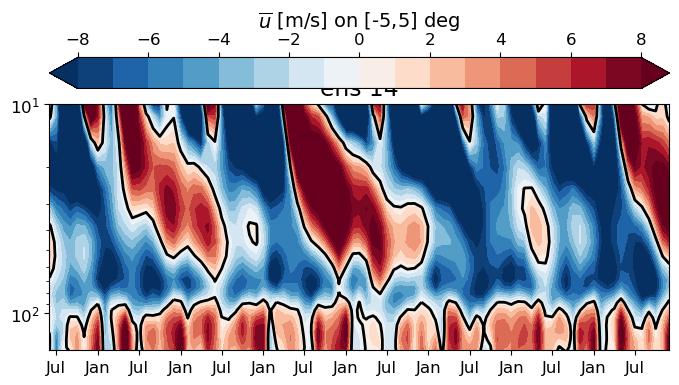

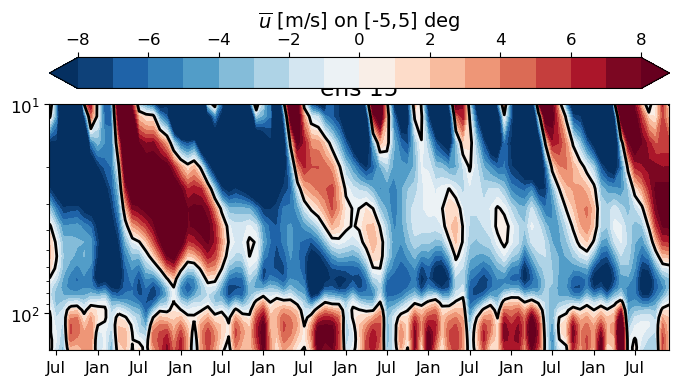

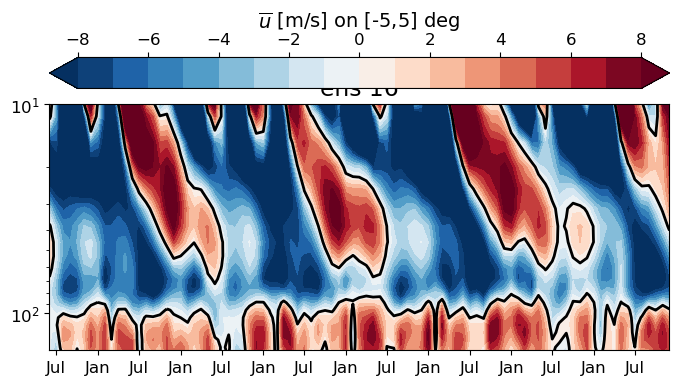

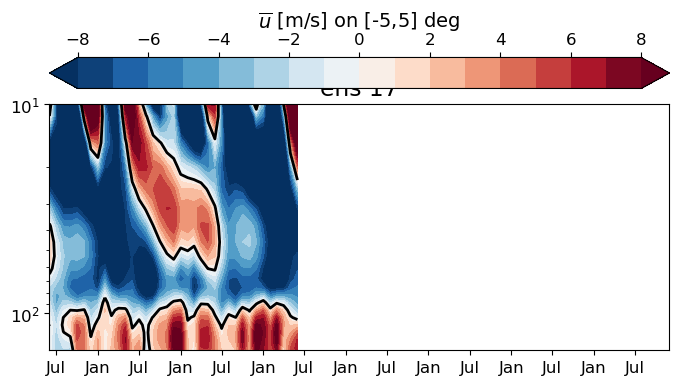

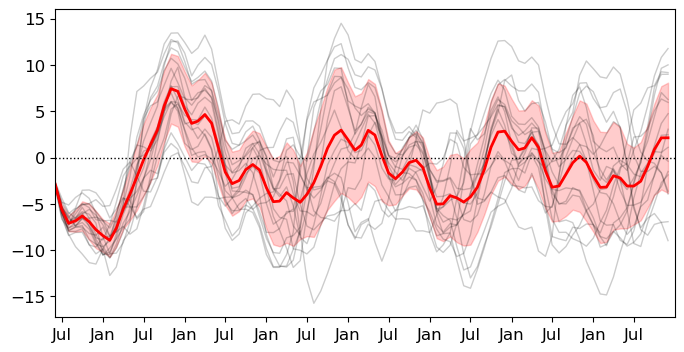

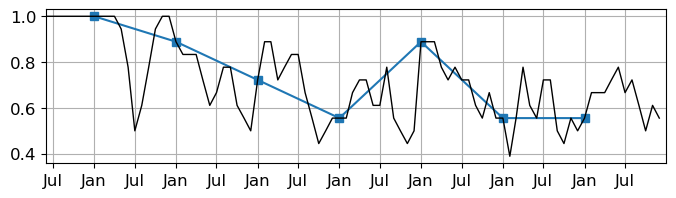

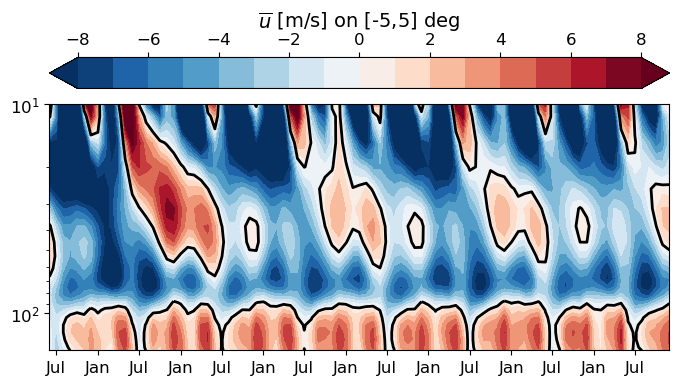

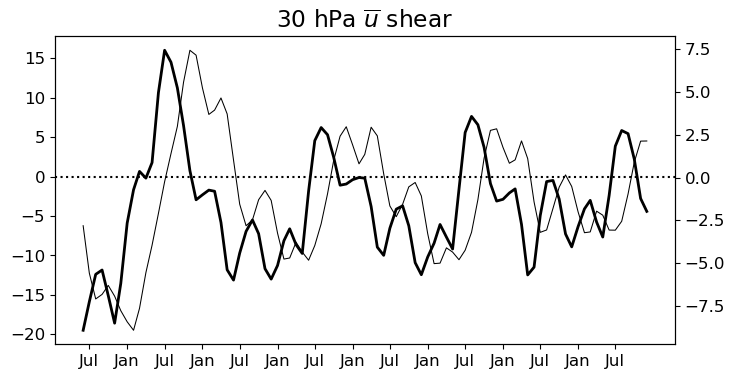

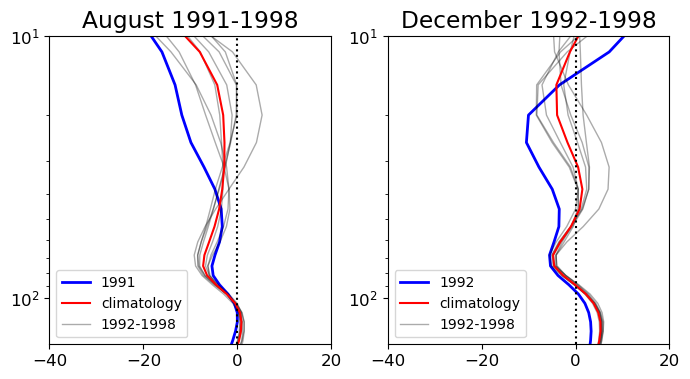

In [13]:
importlib.reload(putil)
importlib.reload(ces)

latb = 5
time = putil.to_datetime(cf.time)
cft = cf.sel(lat=slice(-latb,latb)).mean('lat')
cfmt = cf_mem.sel(lat=slice(-latb,latb)).mean('lat')
climot = climo.sel(lat=slice(-latb,latb)).mean('lat')
topt = {'option':'solstice', 'include_year':False}



# ------- plot time-lev for each member
for i in range(N):
    plt.figure()
    plt.title(f'ens {i}')
    mem = cfmt.isel(ens=i)
    ccc =plt.contourf(time, mem.plev, mem['U'], np.arange(-8, 8.1, 1), cmap='RdBu_r', extend='both')
    plt.contour(time, mem.plev, mem['U'], [0], colors='k', linewidths=2)
    plt.gca().set_ylim([10, 150])
    plt.gca().invert_yaxis()
    plt.gca().set_yscale('log')
    ticks = (np.array([1, 2, 3, 4, 5, 6, 7, 8])*12) - 6
    putil.season_timeticks(plt.gca(), time, **topt)
    plt.colorbar(ccc, label='$\\overline{{u}}$ [m/s] on [{},{}] deg'.format(-latb, latb), location='top', orientation='horizontal')
    plt.gcf().set_size_inches(8, 4)
    
# ----- plot winds at 30 hPa
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 13))
mems = cfmt.sel(plev=30, method='nearest')
for i in range(N):
    mem = mems.isel(ens=i)
    plt.plot(time, mem['U'], '-', color='k', lw=1, alpha=0.2)
mems_mean =  mems['U'].mean('ens')
mems_std  =  mems['U'].std('ens')
plt.plot(time, mems_mean, '-', color='r', lw=2)
plt.fill_between(time, y1=mems_mean-mems_std, y2=mems_mean+mems_std, color='r', alpha=0.2)
plt.gca().axhline(y=0, ls=':', color='k', lw=1)
plt.gca().set_xlim([datetime(1991,6,1),datetime(1999,1,1)])
putil.season_timeticks(plt.gca(), time, **topt)

plt.figure(figsize=(8,2))
coherence = np.sign(mems['U']) == np.sign(cft['U'].sel(plev=30, method='nearest'))
coherence = coherence.sum(dim='ens') / N
cc = coherence
jan_coherence = cc.sel(time=cc.time.where((cc.time.dt.year>1991)&(cc.time.dt.month==1), drop=True))
plt.plot(putil.to_datetime(jan_coherence.time.values), jan_coherence, '-s', lw=1.5)
plt.plot(putil.to_datetime(cc.time.values), cc, '-k', lw=1)
plt.grid()
plt.gca().set_xlim([datetime(1991,6,1),datetime(1999,1,1)])
putil.season_timeticks(plt.gca(), time, **topt)

# ------- plot time-lev 
plt.figure()
ccc =plt.contourf(time, cft.plev, cft['U'], np.arange(-8, 8.1, 1), cmap='RdBu_r', extend='both')
plt.contour(time, cft.plev, cft['U'], [0], colors='k', linewidths=2)
plt.gca().set_ylim([10, 150])
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
putil.season_timeticks(plt.gca(), time, **topt)
plt.colorbar(ccc, label='$\\overline{{u}}$ [m/s] on [{},{}] deg'.format(-latb, latb), location='top', orientation='horizontal')
plt.gcf().set_size_inches(8, 4)


# ------- plot vertical wind profiles
shear = cft['U'].copy()
shear.values = np.gradient(shear, -np.log(cf.plev), axis=shear.dims.index('plev'))
shear = shear.sel(plev=30, method='nearest')

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.set_title('30 hPa $\\overline{{u}}$ shear')
ax.plot(time, shear, '-k', lw=2)
axx = ax.twinx()
axx.plot(time, cft['U'].sel(plev=30, method='nearest'), '-k', lw=0.75)
ax.axhline(y=0, ls=':', color='k')
putil.season_timeticks(ax, time, **topt)


# ------- plot vertical wind profiles
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
years = cft.time.dt.year.values
month = cft.time.dt.month.values

ax1.set_title('August 1991-1998')
for year in np.unique(years):
    if(year==1991):
        label, color, alpha, lw = '1991', 'blue', 1, 2
    else:
        label, color, alpha, lw = None, 'black', 0.33, 1
    ax1.plot(cft['U'].sel(time=cf.time.where((cf.time.dt.year==year)&(cf.time.dt.month==8), drop=True)),\
             cft.plev, '-', color=color, lw=lw, alpha=alpha, label=label)
ax1.plot(climot['U'].sel(month=8), cft.plev, '-r', label='climatology')
ax1.plot([0],[0],'-', color='black', lw=1, alpha=0.33, label='1992-1998')
ax1.legend(loc='lower left', fontsize=10)

ax2.set_title('December 1992-1998')
for year in np.unique(years):
    if(year==1991):
        label, color, alpha, lw = '1992', 'blue', 1, 2
    elif(year>1991):
        label, color, alpha, lw = None, 'black', 0.33, 1
    else: continue
    ax2.plot(cft['U'].sel(time=cf.time.where((cf.time.dt.year==year)&(cf.time.dt.month==12), drop=True)),\
             cft.plev, '-', color=color, lw=lw, alpha=alpha, label=label)
ax2.plot(climot['U'].sel(month=12), cft.plev, '-r', label='climatology')
ax2.plot([0],[0],'-', color='black', lw=1, alpha=0.33, label='1992-1998')
ax2.legend(loc='lower left', fontsize=10)

for ax in [ax1,ax2]:
    ax.set_xlim([-40,20])
    ax.set_ylim([10, 150])
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.axvline(0, ls=':', color='k')

plt.show()